In [17]:
%matplotlib inline
# %matplotlib notebook
import h5py
import rasterio
import rasterio.plot 
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd
import numpy as np
#usar opencv3 para evitar conflictos con rasterio
import cv2 
from matplotlib import cm as CM
import os
import utilidades
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

In [2]:

os.chdir('/home/daniel/AraucoNursery/')
# linux = '/media/daniel/Respaldo/Memoria/Codigo Memoria/'

# windows = 'D:/Memoria/Codigo Memoria/'
# url_imagen = windows + 'CONTEO_SATELITE/imagenes/corte_pequeño.tif'
# corte = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/corte_pequeño.shp'
# shp = windows + 'CONTEO_SATELITE/puntos_arboles/40050_pira_2017_arb.shp'
# rotados = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/puntos_rotados/puntos_rotados.shp'
# rotados = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/puntos_cortados.shp'

# url_imagen = "/media/daniel/Respaldo/Memoria/Codigo/AraucoNursery/PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño.tif"
# rotados = "/media/daniel/Respaldo/Memoria/Codigo/AraucoNursery/PROYECTOS/CONTEO_SATELITE/puntos_rotados.shp"

# url_imagen = "D:/Memoria/Codigo/AraucoNursery/PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño.tif"
url_imagen = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_dron.tif"

rotados = "PROYECTOS/CONTEO_SATELITE/puntos_cortados.shp"

url_salida = "train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = "train/"+str(datetime.datetime.now().day)+"/png/"
url_salida_tiff = "train/"+str(datetime.datetime.now().day)+"/tiff/"
url_salida_shp = "train/"+str(datetime.datetime.now().day)+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [3]:
url_salida

'train/13/'

In [4]:
if not os.path.exists(url_salida):
    os.makedirs(url_salida)
if not os.path.exists(url_salida_png):
    os.makedirs(url_salida_png)
if not os.path.exists(url_salida_tiff):
    os.makedirs(url_salida_tiff)
if not os.path.exists(url_salida_shp):
    os.makedirs(url_salida_shp)

In [5]:
# puntos = gpd.read_file(shp)
puntos = gpd.read_file(rotados)
raster = rasterio.open(url_imagen)

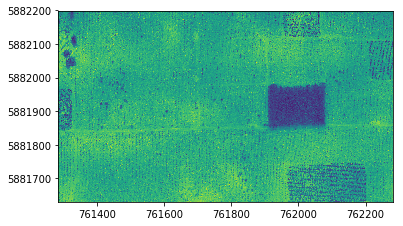

In [6]:
rasterio.plot.show(raster)

In [51]:
# puntos = gpd.read_file(shp)
# 761.774,565  5.881.886,945 Meters

In [52]:
# puntos = puntos.rotate(48.01,origin=(761774.565,5881886.945))
# puntos.to_file(driver = 'ESRI Shapefile', filename = "puntos_rotados")

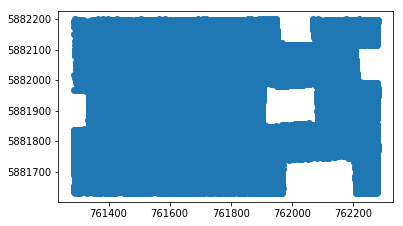

In [7]:
puntos.plot()

In [8]:
url_salida + "pixeles" + ".csv"

'train/13/pixeles.csv'

In [9]:
def get_coordenadas(raster, puntos, url_salida, nombre):
    print(url_salida + nombre + ".csv")
    """
    Dado un raster y un shapefile obtiene las posiciones de los puntos con respecto a x e y de la imagen.
    Genera un csv de la forma x, y (lat, lon)
    :raster: corresponde a una imagen tiff abierta con rasterio
    :puntos: Corresponde a un shapefile abierto en geopandas
    :url_salida: carpeta donde se guardara el csv 
    :nombre: nombre del csv con los puntos
    :return: un array con los puntos de la forma y,x y un csv con los puntos
    """
    coordenadas = []
    pixeles = pd.DataFrame(columns=["x", "y"])
    for index in range(puntos.shape[0]):
        try:
            pl = raster.index(puntos["geometry"][index].bounds[0], puntos["geometry"][index].bounds[1])
            bandera = True
        except:
            print(index)
        if(bandera):
            pixeles.loc[index] = [pl[0], pl[1]]
    pixeles.to_csv(url_salida + nombre + ".csv")

    for element in range(pixeles.shape[0]):
        coordenadas.append([pixeles["y"][element], pixeles["x"][element]])

    return coordenadas, pixeles

In [10]:
coordenadas,pixeles = get_coordenadas(raster,puntos,url_salida,"pixeles")

train/13/pixeles.csv
4924
4925
4926


In [11]:
mapa_densidad = utilidades.get_density_map_gaussian(coordenadas,raster.height,raster.width,sigma = 4)

In [15]:
np.save("mapa_densidad.npy",mapa_densidad)
# np.load(url_salida+"/mapa_densidad" + '.npy')

In [12]:
raster.width,raster.height,mapa_densidad.shape

(13238, 7560, (7560, 13238))

(7560, 13238)


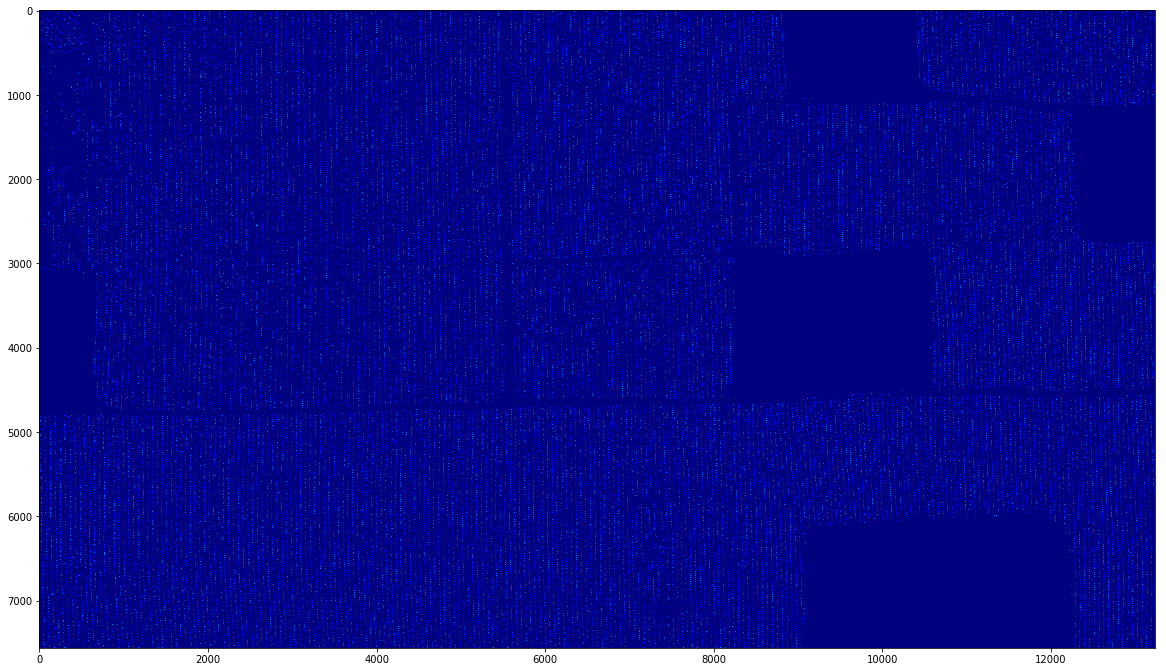

In [18]:
plt.figure(figsize=(20,20))
print(mapa_densidad.shape)
plt.imshow(mapa_densidad,cmap=CM.jet)
# plt.colorbar()
plt.show()

In [19]:
unique, counts = np.unique(mapa_densidad, return_counts=True)
print(np.sum(mapa_densidad),puntos.shape[0])

44992.047 44992


In [23]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 100
nulo = [65535]
lista_imagenes = []
lista_etiquetas = []
lista_mapa = []
contador = 0

In [24]:
# %%time
contador = 0
out_meta = raster.meta.copy()
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
   
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    r = raster.xy(offsetX + width , offsetY)
    l = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)
    minx = min(t[0],l[0],b[0],t[0])
    maxx = max(t[0],l[0],b[0],t[0])
    miny = min(t[1],l[1],b[1],t[1])
    maxy = max(t[1],l[1],b[1],t[1])
    bbox = box(minx, miny, maxx, maxy)  
    try:
#         print(contador)
        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)

        # revisamos que no tenga valores mayores a 255 los reemplazamos por 0
#         out_img[out_img > 255 ] = 0

        # quitamos pixeles irrelevantes   
     
        out_png = out_img[0:3,1:101,1:101]
#         out_img = out_img[:,1:101,0:100]

        if(out_png.shape != (3, 100, 100)):
            offsetX = offsetX + step
            continue
        
#         out_meta.update({"driver": "GTiff",
#                             "height": 100,
#                             "width": 100,
#                             "transform": out_transform,
#                             "crs": raster.crs})
        
        #corte mapa densidad
        corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        
#         interseccion ptos
        interseccion = puntos["geometry"].intersects(bbox)
        puntos_por_imagen = puntos[interseccion]
#         print("ejecuta")
#         puntos_por_imagen.to_file(url_salida_shp+"salida"+str(contador)+".shp")
        cantidad = interseccion.value_counts()

        
        if(True in cantidad.index):
#             print("ejecuta")
            numero = cantidad[True]
#             mpimg.imsave('{}/salida{}.png'.format(url_salida_png,contador), out_png.T)
#             with rasterio.open('{}/salida{}.tif'.format(url_salida_tiff,contador), "w", **out_meta) as dest:
#                 dest.write(out_img)
            lista_imagenes.append(out_png.T)
            lista_mapa.append(corte.T)
            lista_etiquetas.append(numero)
            contador = contador + 1
        else:
            numero = 0
    except ValueError:
        pass
    offsetX = offsetX + step 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


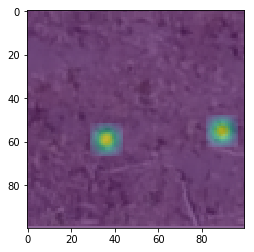

In [28]:
numero = 1206
flip = lista_mapa[numero]
plt.figure()
plt.imshow(lista_imagenes[numero])
plt.imshow(flip,alpha= .6)
plt.show()

In [29]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)
n_lista_mapa = len(lista_mapa)

In [30]:
lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)
lista_mapa = np.array(lista_mapa)

In [31]:
HEIGHT = 100
WIDTH = 100
CHANNELS = 3
factor_reduccion= 4

In [32]:
lista_mapa = utilidades.reduccion_mapa(lista_mapa,factor_reduccion)

In [40]:
hf = h5py.File(archivo_h5_mapa, 'w')

OSError: Unable to create file (unable to truncate a file which is already open)

In [ ]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

In [ ]:
%%time
Yset = hf.create_dataset(
        name= "density",
        data=lista_mapa,
        shape=(n_lista_mapa,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)


In [ ]:
%%time
Zset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_mapa,),
        compression="gzip",
        compression_opts=9)


In [ ]:
Vset = hf.create_dataset(
        name= "density_model",
        data=densidades,
        shape=(n_lista_mapa,HEIGHT/factor_reduccion,WIDTH/factor_reduccion),
        compression="gzip",
        compression_opts=9)

In [ ]:
hf.close()

# Revision de los datos

In [ ]:
numero = 100

with h5py.File('D:/Memoria/Codigo/AraucoNursery/train/3/data_mapa.h5', 'r') as hf:
    imagen = hf["images"][numero]
    densidad = hf["density"][numero]
    densidad_chica =hf["density_model"][numero]

In [ ]:
plt.figure()
plt.subplot(131)
plt.imshow(imagen)
plt.subplot(132)
plt.imshow(densidad)
plt.subplot(133)
plt.imshow(densidad_chica)
plt.show()